# Quantum Circuit Compilation

Quantum Circuit Compilation is a technique that aims to reduce the depth of certain quantum circuits by approximating them by fixed depth variational circuits. A well-known example of this is [quantum assisted quantum compiling](https://quantum-journal.org/papers/q-2019-05-13-140/) (QAQC). This is available in QURI Algo through our compilation module, which will be introduced through this notebook.

## Overview

In this notebook we will go through

- Some background of QAQC
- How to use the Hilbert-Schmidt cost function
- How to use the QURI Algo implementation of QAQC

## QAQC

The objective of QAQC is to approximate a known quantum circuit which is understood to be too deep by a low-depth variational circuit $V(\theta)$. Ideally the depth of $V(\theta)$ is $\mathcal{O}(N_q)$ or $\mathcal{O}(\log N_q)$, which is achievable with either brick-wall or tensor-network inspired ansatze. A cost-function is needed, that when minimized ensures that $U_N(t) = e^{i\phi} V(\theta)$ for some global phase $\phi$.

We can use the Hilbert-Schmidt (HS) test for this which is
$$
    C_\textup{HST}(U,V) = 1 - \frac{1}{4^{N_q}} |\textup{Tr}[U^\dagger V]|^2.
$$
The advantage of this is that it can be evaluated on quantum hardware by sampling a $2N_q$ qubit wavefunction. This has implications for QPE where multi-qubit controlled time-evolution is performed several times. Although the $2N_q$ requirement likely makes the optimization untractable using classical computing, running the optimization using a quantum device requires little additional overhead compared to QPE and has the potential to reduce the run-time of QPE dramatically.

To summarize it briefly, the estimation is done on a $2 N_q$ qubit quantum register consisting of $N_q$-qubit subsystems $A$ and $B$. The system has initially been prepared as a product of Bell states defined by pairs of qubits belonging to $A$ and $B$. Denoting by $A_j$ and $B_j$ the $j$'th qubit on subsystem $A$ and $B$ respectively. We write

$$
    \ket{\Phi}_{A_j,B_j} = \frac{1}{\sqrt{2}}(\ket{00} + \ket{11})_{A_j, B_j}.
$$
Then the initial state is
$$
    \ket{\Phi}_{A,B} = \bigotimes_{j=1}^{N_q} \ket{\Phi}_{A_j,B_j}.
$$
Then $U$ and $V^*$ are applied to the $A$ and $B$ subsystem respectively. The resulting state density matrix is
$$
    \rho_{AB}(U,V) = (U_A\otimes V_B^*)\ket{\Phi}_{A,B}\bra{\Phi}_{A,B}(U_A\otimes V_B^*)^\dagger.
$$
Then measurements are conducted in the basis of pair-wise Bell states $\ket{\Phi}_{A_j,B_j}$. Resultingly, this gives us the HS test because
$$
    \frac{1}{4^{N_q}} |\textup{Tr}[U^\dagger V]|^2 = \textup{Tr}[\Pi_1\Pi_2\ldots\Pi_{N_q}\rho_{AB}(U,V)].
$$
Here the $\Pi_i$ operators are
$$
    \Pi_i = \ket{\Phi}_{A_j,B_j}\bra{\Phi}_{A_j,B_j}.
$$

Another variant is the local HS (LHS) test, which is defined as
$$
    C_\textup{LHST}(U,V) = 1 - \frac{1}{{N_q}} \sum_j^{N_q} C^{(j)}_\textup{LHST}(U,V)
$$
with
$$
    C^{(j)}_\textup{LHST}(U,V) = 1 - \textup{Tr}[\Pi_j\rho_{AB}(U,V)].
$$
We provide the hybrid cost-function
$$
    C_\alpha(U,V) = \alpha C_\textup{HST}(U,V) + (1-\alpha) C_\textup{LHST}(U,V)
$$

When running either the HS or LHS tests the measurements required are the same. For this reason, whenever a series of measurements are performed that result in the HS test, those same measurements if averaged over single Bell pairs could be used to simultaneously compute the LHS test. Therefore the above cost-function is no more expensive than either of its parts. There are certain situations where the LHS results in an optimization landscape that is easier for gradient based optimizers to navigate. This is because the inner product between $U$ and some randomly chosen $V$ is exponentially suppressed due to the scaling of the Hilbert space. The LHS test avoids this issue by weighting the local cost of each pair of qubits equally. So for large systems it is worthwhile to use $\alpha < 1 $.

## Cost function

In this section we will show how to use the HS test. Although the objective of this notebook is to use it for circuit compilation, it is a rather versatile tool, and so when introducing it we will use it to investigate the Trotter time-evolution circuit. By the end of this section we will have experimented with several different Trotter steps and picked one that is faithful to the exact dynamics of our system.

First it needs to be imported from the `cost_functions` module. It needs to be initialized with a quantum compilation backend that will take care of the estimation functions for us. This will use an estimator from QURI Parts.

In [ ]:
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator

from quri_algo.core.cost_functions import HilbertSchmidtTest

hstest = HilbertSchmidtTest(
    create_qulacs_vector_estimator(), alpha=1.0
)  # alpha=1.0 is the default.

Let's test it out.

In [ ]:
import numpy as np

from quri_parts.circuit import QuantumCircuit

test_0 = QuantumCircuit(2)
test_0.add_RZ_gate(0, np.pi)
test_0.add_RX_gate(1, np.pi)
test_1 = QuantumCircuit(2)
test_1.add_RZ_gate(0, 0.5 * np.pi)
test_1.add_RX_gate(1, 0.5 * np.pi)

result = hstest(
    test_0, test_1, alpha=0.7
)  # When calling hstest we can supply an alpha that's different from the one we initialized.
print("The result from HS test is", result)

The result from HS test is _Estimate(value=(0.675+0j), error=0.0)


We can use a time-evolution circuit factory and generate a Trotterized time evolution based on a simple Hamiltonian. Here we pick the Heisenberg interaction on a spin-1/2 lattice with periodic boundary conditions. We will compute and plot
$$
f(t) = C_\textup{HST}(U(0),U(t))
$$
with $U$ being either the exact time-evolution operator or the one generated by Trotterization.

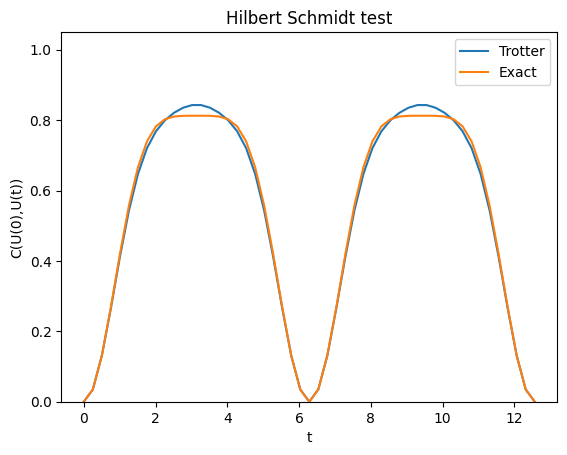

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import linspace

from quri_parts.core.operator import Operator, pauli_label
from quri_algo.circuit.time_evolution.trotter_time_evo import (
    TrotterTimeEvolutionCircuitFactory,
)
from quri_algo.circuit.time_evolution.exact_unitary import (
    ExactUnitaryTimeEvolutionCircuitFactory,
)
from quri_algo.problem.hamiltonian import QubitHamiltonianInput

s = 1 / 2
j = 1.0

heisenberg = Operator(
    {
        pauli_label("X0 X1"): j * s**2,
        pauli_label("X1 X2"): j * s**2,
        pauli_label("X2 X3"): j * s**2,
        pauli_label("X3 X0"): j * s**2,
        pauli_label("Y0 Y1"): j * s**2,
        pauli_label("Y1 Y2"): j * s**2,
        pauli_label("Y2 Y3"): j * s**2,
        pauli_label("Y3 Y0"): j * s**2,
        pauli_label("Z0 Z1"): j * s**2,
        pauli_label("Z1 Z2"): j * s**2,
        pauli_label("Z2 Z3"): j * s**2,
        pauli_label("Z3 Z0"): j * s**2,
    }
)
heisenberg_input = QubitHamiltonianInput(4, heisenberg)
circuit_factory = TrotterTimeEvolutionCircuitFactory(heisenberg_input, 1)
exact_time_evolution_factory = ExactUnitaryTimeEvolutionCircuitFactory(heisenberg_input)

start_circuit = circuit_factory(0.0)
evo_times = linspace(0, 4 * np.pi, 51)
hs_result_trotter = [
    hstest(start_circuit, circuit_factory(time), alpha=0.5).value.real
    for time in evo_times
]
hs_result_exact = [
    hstest(start_circuit, exact_time_evolution_factory(time), alpha=0.5).value.real
    for time in evo_times
]


ax = plt.axes()

ax.plot(evo_times, hs_result_trotter)
ax.plot(evo_times, hs_result_exact)
ax.set_title("Hilbert Schmidt test")
ax.set_xlabel("t")
ax.set_ylabel("C(U(0),U(t))")
ax.set_ybound(0.0, 1.05)
ax.legend(["Trotter", "Exact"])

With just a single Trotter step, there seems to be some discrepancy in the time-evolution. From the above result we cannot tell how accurate the Trotterization is for this system, what the result does tell us that the Hilbert Schmidt cost function does not agree entirely with the exact time-evolution. However, interestingly the Trotterized time-evolution operator shows the same periodicity in $t$ as its exact counterpart. When the Hilbert Schmidt cost function reaches 0 the two input unitaries are equivalent, which shows that the time evolution operator has undergone a full period of time-evolution. This is in fact not too surprising since the Trotterized time-evolution operator is a product of unitaries, each of which is parametrized with respect to $t$ displaying the same periodicity. To see how accurate the Trotterized time evolution operator itself is, we would need to calculate $C(U_\textup{exact}(t),U_\textup{Trotter}(t))$.

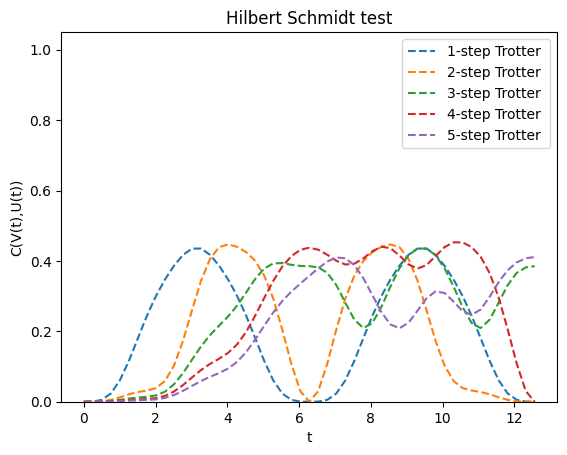

In [ ]:
evo_times = linspace(0, 4 * np.pi, 51)

ax = plt.axes()

max_trotter = 5
hs_results_trotter = []
legend = []
for i in range(1, max_trotter + 1):
    circuit_factory = TrotterTimeEvolutionCircuitFactory(heisenberg_input, i)
    hs_result_trotter = [
        hstest(exact_time_evolution_factory(time), circuit_factory(time)).value.real
        for time in evo_times
    ]

    ax.plot(evo_times, hs_result_trotter, "--")
    legend.append(str(i) + "-step Trotter ")

ax.set_title("Hilbert Schmidt test")
ax.set_xlabel("t")
ax.set_ylabel("C(V(t),U(t))")
ax.set_ybound(0.0, 1.05)
ax.legend(legend)

Interestingly there does not seem to be any significant improvement in the range of 1 - 5 Trotter steps. However, for the trend is that a higher number of Trotter steps results in more accurate time-evolution for small $t$. Let's go higher

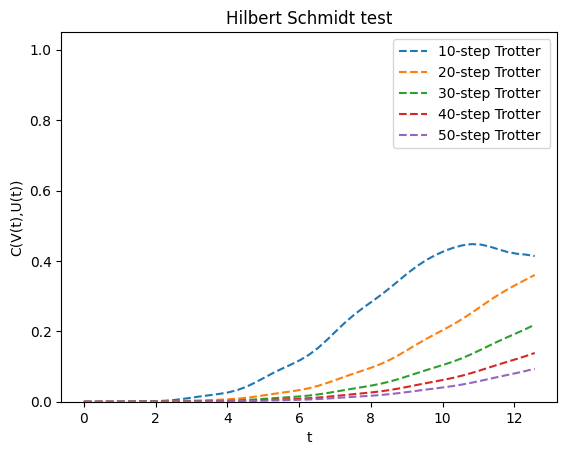

In [ ]:
evo_times = linspace(0, 4 * np.pi, 51)

ax = plt.axes()

trotter_steps = [10, 20, 30, 40, 50]
hs_results_trotter = []
legend = []
for i in trotter_steps:
    circuit_factory = TrotterTimeEvolutionCircuitFactory(heisenberg_input, i)
    hs_result_trotter = [
        hstest(exact_time_evolution_factory(time), circuit_factory(time)).value.real
        for time in evo_times
    ]

    ax.plot(evo_times, hs_result_trotter, "--")
    legend.append(str(i) + "-step Trotter ")

ax.set_title("Hilbert Schmidt test")
ax.set_xlabel("t")
ax.set_ylabel("C(V(t),U(t))")
ax.set_ybound(0.0, 1.05)
ax.legend(legend)

We see the same trend repeated again. For $n_\textup{Trotter} = 50$, the time-evolution should be rather faithful in the range $0 < t \leq 2\pi$ which makes up a single period of the repeating dynamics. Finally, let's experiment with the circuit compilation itself

## Quantum compilation

The QAQC compiler itself needs to be initialized using an optimizer and a cost function. Below we will instantiate one with an ideal estimator.

In [ ]:
from quri_parts.algo.optimizer import Adam

from quri_algo.algo.compiler import QAQC

NSHOTS = 10000
ALPHA = 1.0

ideal_estimator = create_qulacs_vector_estimator()
optimizer = Adam()
ideal_cost_fn = HilbertSchmidtTest(ideal_estimator, alpha=ALPHA)

ideal_compiler = QAQC(ideal_cost_fn, optimizer)

Now to run it, we need to provide a circuit factory. A circuit factory is some callable object that based on the call argument returns a `QuantumCircuit`. We can use the `TrotterTimeEvolutionCircuitFactory` that we employed earlier. We will also need a variational ansatz, for this we can pick any ansatz in principle. To keep things simple we use the `HardwareEfficientReal` ansatz

In [ ]:
from quri_parts.algo.ansatz import (
    HardwareEfficient,
    build_entangler_map,
    EntanglementPatternType,
)

REPS = 8
time = np.pi / 20

entangler_map = build_entangler_map(
    heisenberg_input.n_state_qubit, [EntanglementPatternType.CIRCULAR] * REPS
)  # Building a circular entangler map will map to a problem with a perdiodic boundary
ansatz = HardwareEfficient(
    heisenberg_input.n_state_qubit, REPS, entangler_map_seq=entangler_map
)
circuit_factory = TrotterTimeEvolutionCircuitFactory(heisenberg_input, 50)

ideal_compiled = ideal_compiler(
    circuit_factory, ansatz, evolution_time=time
)  # Keyword arguments get passed to the circuit factory, which allows us to pass quite general circuit factories.

print(
    "The HS cost of the compiled circuit is:",
    hstest(circuit_factory(time), ideal_compiled).value.real,
)

The HS cost of the compiled circuit is: 0.01838424101680985


It seem like we can compile circuits to a rather shallow depth. Comparison of the circuit depths yields

In [ ]:
print(
    f"The depth of the Trotterized time-evolution with HS cost {hstest(exact_time_evolution_factory(time),circuit_factory(time)).value.real} is {circuit_factory(time).depth}"
)
print(
    f"The depth of the compiled time-evolution with HS cost {hstest(exact_time_evolution_factory(time),ideal_compiled).value.real} is {ideal_compiled.depth}"
)

The depth of the Trotterized time-evolution with HS cost 2.2457534867327544e-08 is 600
The depth of the compiled time-evolution with HS cost 0.018384172277586742 is 34


So we are able to trade quantum circuit faithfullness for a dramatic reduction in circuit depth. For NISQ or EFTQC devices the above difference in depth easily makes the difference between whether a circuit can be executed on quantum hardware or not.

### How well does it perform on a real device?

In this section we will compare the Trotter time-evolution with the compiled time-evolution and estimate the fidelity on a STAR architecture VM.

In [ ]:
from pprint import pprint

from quri_parts.backend.devices import star_device
from quri_parts.backend.units import TimeValue, TimeUnit
from quri_vm import VM

n_device_logical_qubit = ideal_compiled.qubit_count
p_phys = 1e-4
qec_cycle = TimeValue(1, TimeUnit.MICROSECOND)
code_distance = 9

star_property = star_device.generate_device_property(
    n_device_logical_qubit, code_distance, qec_cycle, p_phys,
)
star_vm = VM.from_device_prop(star_property)

analysis_ideal_compiled = star_vm.analyze(ideal_compiled)
analysis_trotterized = star_vm.analyze(circuit_factory(time))

pprint(analysis_ideal_compiled)
pprint(analysis_trotterized)

AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=4,
              gate_count=348,
              depth=96,
              latency=TimeValue(value=2367000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.9980266516222808)
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=4,
              gate_count=6100,
              depth=3700,
              latency=TimeValue(value=83700000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.9822051732162591)


The discrepancy in depth from the above analysis to the QURI Parts circuit comes from the fact that the VM object we use automatically transpiles the circuit to the device's gate set.

As seen here the infidelity is about an order of magnitude lower for the compiled circuit due to the much lower depth. Although the STAR architecture is still expected to be able to run the circuit of the 50-step Trotterized time-evolution, it will likely result in inaccurate results.

How about a NISQ device?

In [ ]:
from quri_parts.circuit.topology import SquareLattice
from quri_parts.backend.devices import nisq_spcond_lattice

nisq_spcond_vm = VM.from_device_prop(
    nisq_spcond_lattice.generate_device_property(
        lattice=SquareLattice(4, 4),
        native_gates_1q=("RZ", "SqrtX", "X"),
        native_gates_2q=("CNOT",),
        gate_error_1q=1e-4,
        gate_error_2q=1e-3,
        gate_error_meas=1e-2,
        gate_time_1q=TimeValue(60, TimeUnit.NANOSECOND),
        gate_time_2q=TimeValue(660, TimeUnit.NANOSECOND),
        gate_time_meas=TimeValue(1.4, TimeUnit.MICROSECOND),
    )
)

analysis_ideal_compiled = nisq_spcond_vm.analyze(ideal_compiled)
analysis_trotterized = nisq_spcond_vm.analyze(circuit_factory(time))

pprint(analysis_ideal_compiled)
pprint(analysis_trotterized)

AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=4,
              gate_count=720,
              depth=331,
              latency=TimeValue(value=91860.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.8292223020688096)
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=4,
              gate_count=12050,
              depth=7850,
              latency=TimeValue(value=3120000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.003976163562366794)


Here the difference in fidelity is much more noticable, which is not surprising given the lack of any error correction.

## Summary

In this notebook we 

- Introduced quantum compilation with an emphasis on QAQC and the HS test
- Showed how to execute the HS test in QURI Algo to evaluate quantum circuits in terms of their faithfulness to exact time-evolution
- Ran QAQC on a simple example with the spin-1/2 Heisenberg model on 4 spins with a periodic boundary

QAQC is a powerful technique, but it's rather slow, and the optimization itself is difficult. Evaluating the HS cost function is expensive as the number of qubits needed is twice that of the circuits being compared. There are solutions to this however, notably if the dynamics are only accounted for within the Lieb-Robinson bound, in which cases the local dynamics only are taken into account. This results in the [local variational quantum compilation](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.040302) algorithm, which we provide in our proprietary version of QURI Algo.

### Further study

Now that you have familiarized yourself with QAQC try using it with a more complex model. The model we used in this notebook is the Heisenberg model, but what happens if you replace it with a model with next-nearest neighbor interactions? Will the circuits still compile as easily? What is the Hilbert-Schmidt test value you will end up with?